In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items') 
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Swara.2003',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/hp/OneDrive/Desktop/archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
db=mysql.connector.connect(
    host='localhost',
    user='root',
    password='Swara.2003',
    database='ecommerce'
)
cursor = db.cursor()


# List all unique cities where customers are located.


In [4]:
query=""" select distinct customer_city from customers"""
cursor.execute(query)
data= cursor.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [5]:
query=""" select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cursor.execute(query)
data= cursor.fetchall()
data[0][0]
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 135303)

# Find the total sales per category.

In [6]:
query=""" select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""
cursor.execute(query)
data= cursor.fetchall()
df =pd.DataFrame(data,columns=["Category","sales"])
df

,Category,sales
0,PERFUMERY,13681943.82
1,FURNITURE DECORATION,38614762.58
2,TELEPHONY,13145815.37
3,BED TABLE BATH,46238949.12
4,AUTOMOTIVE,23011946.94
...,...,...
69,CDS MUSIC DVDS,32384.61
70,LA CUISINE,78665.31
71,FASHION CHILDREN'S CLOTHING,21213.09
72,PC GAMER,58709.61


# Calculate the percentage of orders that were paid in installments.

In [7]:
query=""" select(sum(case when payment_installments >=1 then 1 else 0 end))/count(*)*100 from payments"""
cursor.execute(query)
data= cursor.fetchall()
data[0][0]
"percantage of orders that were paid in installments ", data[0][0]

('percantage of orders that were paid in installments ', Decimal('99.9981'))

In [8]:
query=""" select(sum(case when payment_installments >1 then 1 else 0 end))/count(*)*100 from payments"""
cursor.execute(query)
data= cursor.fetchall()
data[0][0]
"percantage of orders that were paid in installments ", data[0][0]

('percantage of orders that were paid in installments ', Decimal('49.4176'))

# Count the number of customers from each state

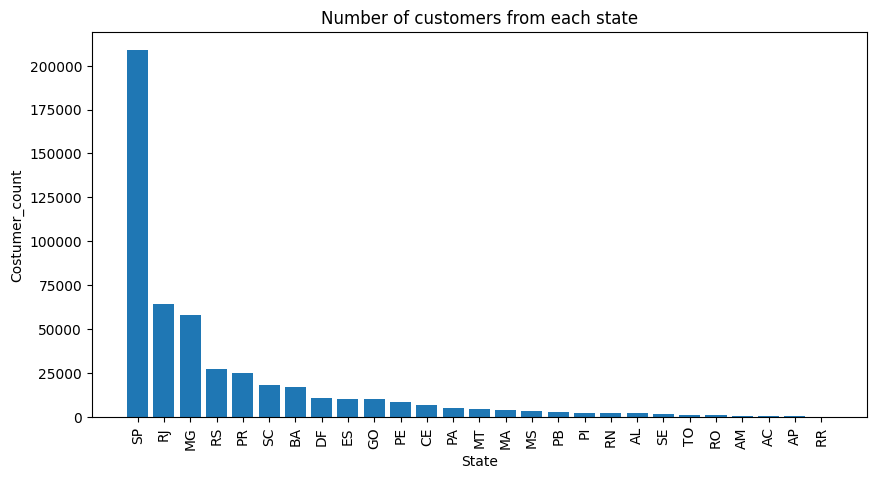

In [9]:
query="""select customer_state, count(customer_id)
from customers group by customer_state"""
cursor.execute(query)
data= cursor.fetchall()
df=pd.DataFrame(data, columns=["state", "costumer_count"])
df=df.sort_values(by = "costumer_count", ascending=False)
plt.figure(figsize=(10,5))
plt.bar(df["state"],df["costumer_count"])
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Costumer_count")
plt.title("Number of customers from each state")
plt.show()



 # Calculate the number of orders per month in 2018.

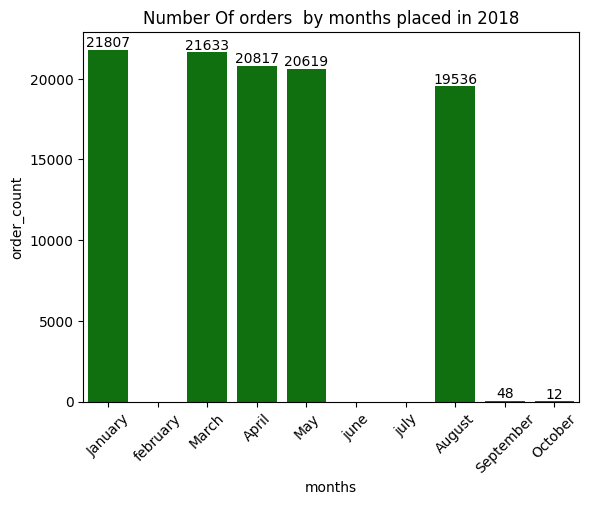

In [10]:
query=""" select monthname(order_purchase_timestamp) months,count(order_id) order_count from 
orders where year(order_purchase_timestamp)=2018
group by months"""
cursor.execute(query)
data= cursor.fetchall()
df =pd.DataFrame(data,columns=["months", "order_count"])
o=["January","february","March","April","May","june","july","August","September","October"]
ax=sns.barplot(x=df["months"],y=df["order_count"],data=df,order=o,color="green")
ax.bar_label(ax.containers[0])

plt.xticks(rotation =45)
plt.title("Number Of orders  by months placed in 2018")
plt.show()


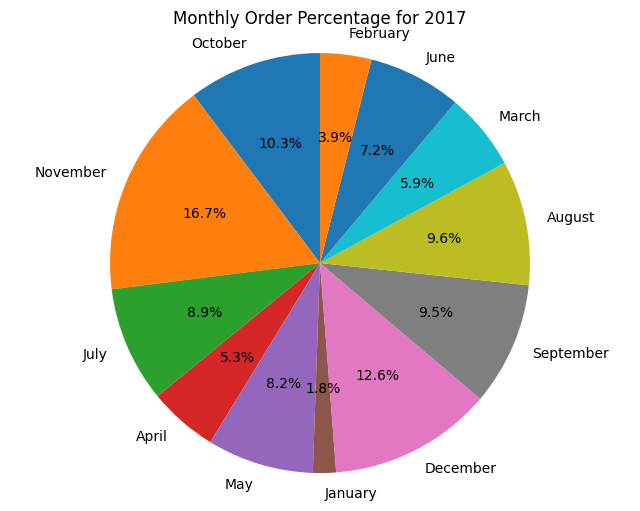

In [62]:


query = """
SELECT MONTHNAME(order_purchase_timestamp) AS month,
       COUNT(order_id) AS order_count
FROM orders
WHERE YEAR(order_purchase_timestamp) = 2017
GROUP BY month
"""
cursor.execute(query)
data = cursor.fetchall()

# Convert to DataFrame
df = pd.DataFrame(data, columns=["month", "order_count"])

# Calculate percentage
df["percentage"] = (df["order_count"] / df["order_count"].sum()) * 100


plt.figure(figsize=(8, 6))
plt.pie(df["percentage"], labels=df["month"], autopct='%1.1f%%', startangle=90)
plt.title("Monthly Order Percentage for 2017")
plt.axis("equal")
plt.show()


# Find the average number of products per order, grouped by customer city.


In [63]:
query = """with count_per_order as (
    select 
        orders.order_id,
        orders.customer_id,
        count(order_items.order_id) as oc
    from orders
    join order_items on orders.order_id = order_items.order_id
    group by orders.order_id, orders.customer_id
)

select 
    customers.customer_city,
    round(avg(count_per_order.oc), 2) as average_order
from customers
join count_per_order on customers.customer_id = count_per_order.customer_id
group by customers.customer_city;"""

cursor.execute(query)
data= cursor.fetchall()
df= pd.DataFrame(data, columns=["city", "avarage_count"])
df

,city,avarage_count
0,abadia dos dourados,9.00
1,abadiania,9.00
2,abaete,9.00
3,abaetetuba,11.45
4,abaiara,9.00
...,...,...
4105,xinguara,10.00
4106,xique-xique,9.00
4107,zacarias,9.00
4108,ze doca,9.00


# Calculate the percentage of total revenue contributed by each product category.

In [17]:

query= """SELECT 
    UPPER(p.product_category) AS category,
    ROUND(SUM(pay.payment_value) * 100.0 / (SELECT SUM(payment_value) FROM payments), 2) AS sales_percentage
FROM 
    products p
JOIN 
    order_items oi ON p.product_id = oi.product_id
JOIN 
    payments pay ON pay.order_id = oi.order_id
GROUP BY 
    UPPER(p.product_category)
ORDER BY 
    sales_percentage DESC
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["category", "sales_percentage"])
df.head()


,category,sales_percentage
0,BED TABLE BATH,96.28
1,HEALTH BEAUTY,93.18
2,COMPUTER ACCESSORIES,89.13
3,FURNITURE DECORATION,80.40
4,WATCHES PRESENT,80.35


# Identify the correlation between product price and the number of times a product has been purchased

In [23]:
import numpy as np

query = """SELECT 
    products.product_category,
    COUNT(order_items.product_id) AS order_count,
    ROUND(AVG(order_items.price), 2) AS avg_price
FROM 
    products 
JOIN 
    order_items ON products.product_id = order_items.product_id
GROUP BY 
    products.product_category
"""

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns=["category", "order_count", "price"])

# Convert columns to numeric types just in case
arr1 = pd.to_numeric(df["order_count"])
arr2 = pd.to_numeric(df["price"])

# Compute correlation coefficient
correlation = np.corrcoef(arr1, arr2)

correlation


array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue.

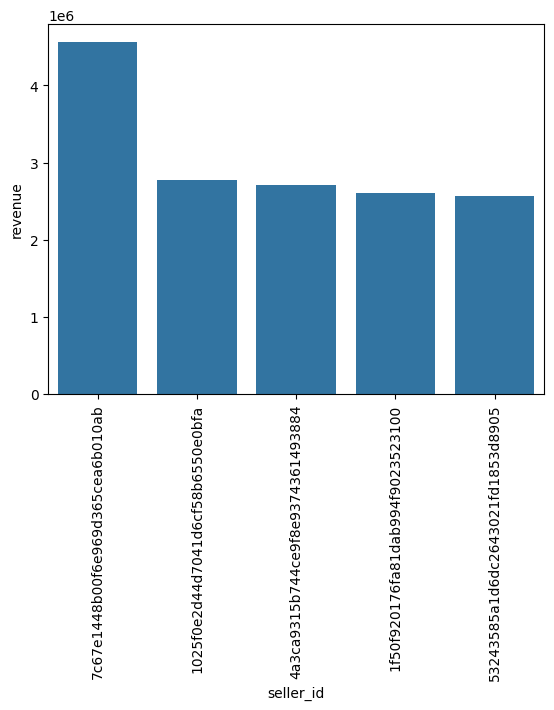

In [39]:
query = """select*, dense_rank() over (order by revenue desc ) from
(select order_items.seller_id,sum(payments.payment_value) 
revenue from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a"""

cursor.execute(query)
data = cursor.fetchall()
df=pd.DataFrame(data, columns=["seller_id","revenue","rank"])
df=df.head()
sns.barplot(x = "seller_id", y= "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()




In [46]:
query="""select customer_id,order_purchase_timestamp,payment,avg(payment) 
over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) 
as mov_avg from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id) as a"""
cursor.execute(query)
data = cursor.fetchall()
df=pd.DataFrame(data)
df



,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
934969,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934970,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934971,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934972,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


In [48]:
query=""" SELECT 
    years,
    months,
    payment,
    SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales
FROM (
    SELECT 
        EXTRACT(YEAR FROM orders.order_purchase_timestamp) AS years,
        EXTRACT(MONTH FROM orders.order_purchase_timestamp) AS months,
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM 
        orders 
    JOIN 
        payments ON orders.order_id = payments.order_id
    GROUP BY 
        years, months
    ORDER BY 
        years, months
) AS a
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["year", "month", "monthly_sales", "cumulative_sales"])
df


,year,month,monthly_sales,cumulative_sales
0,2016,9,2270.16,2.270160e+03
1,2016,10,531814.32,5.340845e+05
2,2016,12,176.58,5.342611e+05
3,2017,1,1246392.36,1.780653e+06
4,2017,2,2627172.09,4.407826e+06
5,2017,3,4048772.40,8.456598e+06
6,2017,4,3760092.27,1.221669e+07
7,2017,5,5336269.38,1.755296e+07
8,2017,6,4601487.42,2.215445e+07
9,2017,7,5331446.28,2.748589e+07


# Calculate the year-over-year growth rate of total sales.

In [52]:
 query=""" with a as (SELECT 
        EXTRACT(YEAR FROM orders.order_purchase_timestamp) AS years,
       
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM 
        orders 
    JOIN 
        payments ON orders.order_id = payments.order_id
    GROUP BY 
        years
    ORDER BY 
        years)
        select years,((payment - lag(payment,1) over (order by years))/ 
        lag(payment,1) over (order by years))*100 from a"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["year", "yoy % growth" ])
df



,year,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'a9dc96b027d1252bbac0a9b72d837fc6'),
  Text(1, 0, '1d34ed25963d5aae4cf3d7f3a4cda173'),
  Text(2, 0, '4a06381959b6670756de02e07b83815f'),
  Text(3, 0, '1617b1357756262bfa56ab541c47bc16'),
  Text(4, 0, 'c6e2731c5b391845f6800c97401a43a9'),
  Text(5, 0, '3fd6777bbce08a352fddd04e4a7cc8f6'),
  Text(6, 0, 'ec5b2ba62e574342386871631fafd3fc'),
  Text(7, 0, 'f48d464a0baaea338cb25f816991ab1f'),
  Text(8, 0, 'e0a2412720e9ea4f26c1ac985f6a7358')])

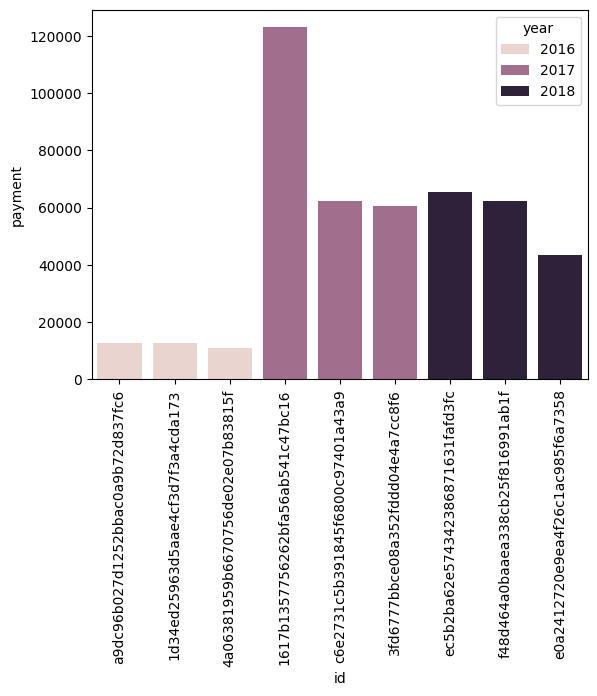

In [60]:
query = """
SELECT years, customer_id, payment, d_rank
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY YEAR(orders.order_purchase_timestamp)
            ORDER BY SUM(payments.payment_value) DESC
        ) AS d_rank
    FROM orders
    JOIN payments ON payments.order_id = orders.order_id
    GROUP BY years, orders.customer_id
) AS a 
WHERE d_rank <= 3
"""


cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["year", "id", "payment", "rank"])
sns.barplot(x="id", y="payment", data = df, hue= "year")
plt.xticks(rotation=90)
